### Setup

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

!ln -s /content/gdrive/ /mydrive

Mounted at /content/gdrive


In [ ]:
import os
import psutil
def human_size(bytes, units=[' bytes', 'KB', 'MB', 'GB', 'TB', 'PB', 'EB']):
  return str(bytes) + units[0] if bytes < 1024 else human_size(bytes>>10, units[1:])

mem = psutil.virtual_memory().total
free_mem = psutil.virtual_memory().available
hdd = psutil.disk_usage('/content/')

print(f"CPU Count: {os.cpu_count()}")
print(f"Memory: {human_size(mem)}")
print(f"Free Memory: {human_size(free_mem)}")
print(f"HD Total: {human_size(hdd.total)}")
print(f"HD Used: {human_size(hdd.used)}")
print(f"HD Free: {human_size(hdd.free)}")

import tensorflow as tf

from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()

for d in devices:
  t = d.device_type
  name = d.physical_device_desc
  l = [item.split(':', 1) for item in name.split(", ")]
  name_attr = dict([x for x in l if len(x)==2])
  dev = name_attr.get('name', 'Unamed device')
  print(f" {d.name} || {dev} || {t} || {human_size(d.memory_limit)}")

CPU Count: 2
Memory: 12GB
Free Memory: 11GB
HD Total: 166GB
HD Used: 42GB
HD Free: 124GB
 /device:CPU:0 || Unamed device || CPU || 256MB
 /device:GPU:0 ||  Tesla P100-PCIE-16GB || GPU || 15GB


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb 24 05:04:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip -q install timm

     |████████████████████████████████| 431 kB 10.2 MB/s 


In [ ]:
from __future__ import print_function

import glob
from itertools import chain
import time
import os
import random
import zipfile
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import timm

%config InlineBackend.figure_format = 'retina'

In [ ]:
print(f"Torch: {torch.__version__}")

Torch: 1.10.0+cu111


### Load Data and Configure Training settings

In [ ]:
# Training settings
batch_size = 32
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [ ]:
import torchvision.transforms.functional as F

class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return F.pad(image, padding, 0, 'constant')

In [ ]:
TRANSFORM_IMG = transforms.Compose([
    SquarePad(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225] )
    ])

In [ ]:
!cp -r '/content/gdrive/MyDrive/Dataset/COVID-CT-Dataset_augmented_split' '/content/COVID-CT-Dataset_augmented_split'

In [ ]:
import torchvision
from torchvision.transforms import ToTensor

train_data = torchvision.datasets.ImageFolder('/content/COVID-CT-Dataset_augmented_split/train', transform=TRANSFORM_IMG)
valid_data = torchvision.datasets.ImageFolder('/content/COVID-CT-Dataset_augmented_split/val', transform=TRANSFORM_IMG)
test_data = torchvision.datasets.ImageFolder('/content/COVID-CT-Dataset_augmented_split/test', transform=TRANSFORM_IMG)

In [ ]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader  = data.DataLoader(test_data, batch_size=batch_size, shuffle=True) 

In [ ]:
print(len(train_data), len(train_loader))
print(len(valid_data), len(valid_loader))
print(len(test_data), len(test_loader))

2984 94
372 12
374 12


In [ ]:
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k',
 'crossvit_9_240',
 'crossv

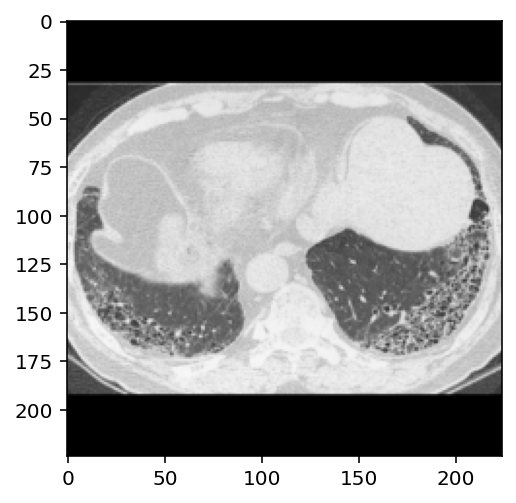

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
plt.imshow(np.transpose(images[3].numpy(), (1, 2, 0)))

## ConViT Small


In [ ]:
device = 'cuda'

model = timm.create_model('convit_small', pretrained=True, num_classes=2).to(device)

Downloading: "https://dl.fbaipublicfiles.com/convit/convit_small.pth" to /root/.cache/torch/hub/checkpoints/convit_small.pth


In [ ]:
model

ConViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 432, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((432,), eps=1e-06, elementwise_affine=True)
      (attn): GPSA(
        (qk): Linear(in_features=432, out_features=864, bias=False)
        (v): Linear(in_features=432, out_features=432, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=432, out_features=432, bias=True)
        (pos_proj): Linear(in_features=3, out_features=9, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((432,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=432, out_features=1728, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=1728, out_features=432, b

### Training

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

n_epochs_stop = 3

min_val_loss = 10

In [ ]:
epoch_l = []
loss_l = []
acc_l = []
v_loss_l = []
v_acc_l = []

In [ ]:
since = time.time()
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
        
        epoch_l.append(epoch+1)
        loss_l.append(epoch_loss)
        acc_l.append(epoch_accuracy)
        v_loss_l.append(epoch_val_loss)
        v_acc_l.append(epoch_val_accuracy)
        
        print(f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n")
        
        if epoch_val_loss < min_val_loss:
            # Saving the model
            best_model = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            min_val_loss = epoch_val_loss
            # early_stoped = False

        # else:
            # epochs_no_improve += 1
            # Check early stopping condition
            # if epochs_no_improve == n_epochs_stop:
                # print('Early stopping!' )
                # model.load_state_dict(best_model)
                # early_stoped = True
                # break
    # if early_stoped:
        # break

elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.4327 - acc: 0.8019 - val_loss : 0.3136 - val_acc: 0.8766



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.1280 - acc: 0.9598 - val_loss : 0.2774 - val_acc: 0.8953



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0447 - acc: 0.9857 - val_loss : 0.1280 - val_acc: 0.9479



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0172 - acc: 0.9953 - val_loss : 0.1837 - val_acc: 0.9359



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0353 - acc: 0.9857 - val_loss : 0.1478 - val_acc: 0.9557



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.0067 - acc: 0.9983 - val_loss : 0.1772 - val_acc: 0.9427



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.0069 - acc: 0.9983 - val_loss : 0.2017 - val_acc: 0.9516



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.0015 - acc: 1.0000 - val_loss : 0.1811 - val_acc: 0.9375



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.0038 - acc: 0.9990 - val_loss : 0.2340 - val_acc: 0.9021



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.0298 - acc: 0.9887 - val_loss : 0.2471 - val_acc: 0.9250



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.0146 - acc: 0.9943 - val_loss : 0.2535 - val_acc: 0.9349



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.0138 - acc: 0.9957 - val_loss : 0.4026 - val_acc: 0.9109



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.0132 - acc: 0.9950 - val_loss : 0.1362 - val_acc: 0.9583



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.0060 - acc: 0.9980 - val_loss : 0.1693 - val_acc: 0.9490



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.0007 - acc: 1.0000 - val_loss : 0.1205 - val_acc: 0.9594



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.1511 - val_acc: 0.9635



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.1305 - val_acc: 0.9609



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1306 - val_acc: 0.9594



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1304 - val_acc: 0.9609



  0%|          | 0/94 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1364 - val_acc: 0.9594

Training completed in 20m 13s


In [ ]:
torch.save(model, './convit_small_model_pretrained.pt')

### Testing

In [ ]:
since = time.time()

y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

def flatten(new:list, target:list):
    for li in target:
        for value in list(li):
            new.append(value)

y_pred = []
y_true = []
flatten(y_pred, y_pred_list)
flatten(y_true, y_true_list)

elapsed_time = time.time() - since
print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

  0%|          | 0/12 [00:00<?, ?it/s]

Evaluation completed in 0m 4s


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
print("Overall accuracy:", accuracy_score(y_true, y_pred))
print("Overall F1:", f1_score(y_true, y_pred, average='weighted'))
print("Overall Loss:", log_loss(y_true, y_pred))

Overall accuracy: 0.9786096256684492
Overall F1: 0.9786016350113713
Overall Loss: 0.7388080458460876


In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_true, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.98265896 0.97512438]
recall: [0.97142857 0.98492462]
fscore: [0.97701149 0.98      ]
support: [175 199]


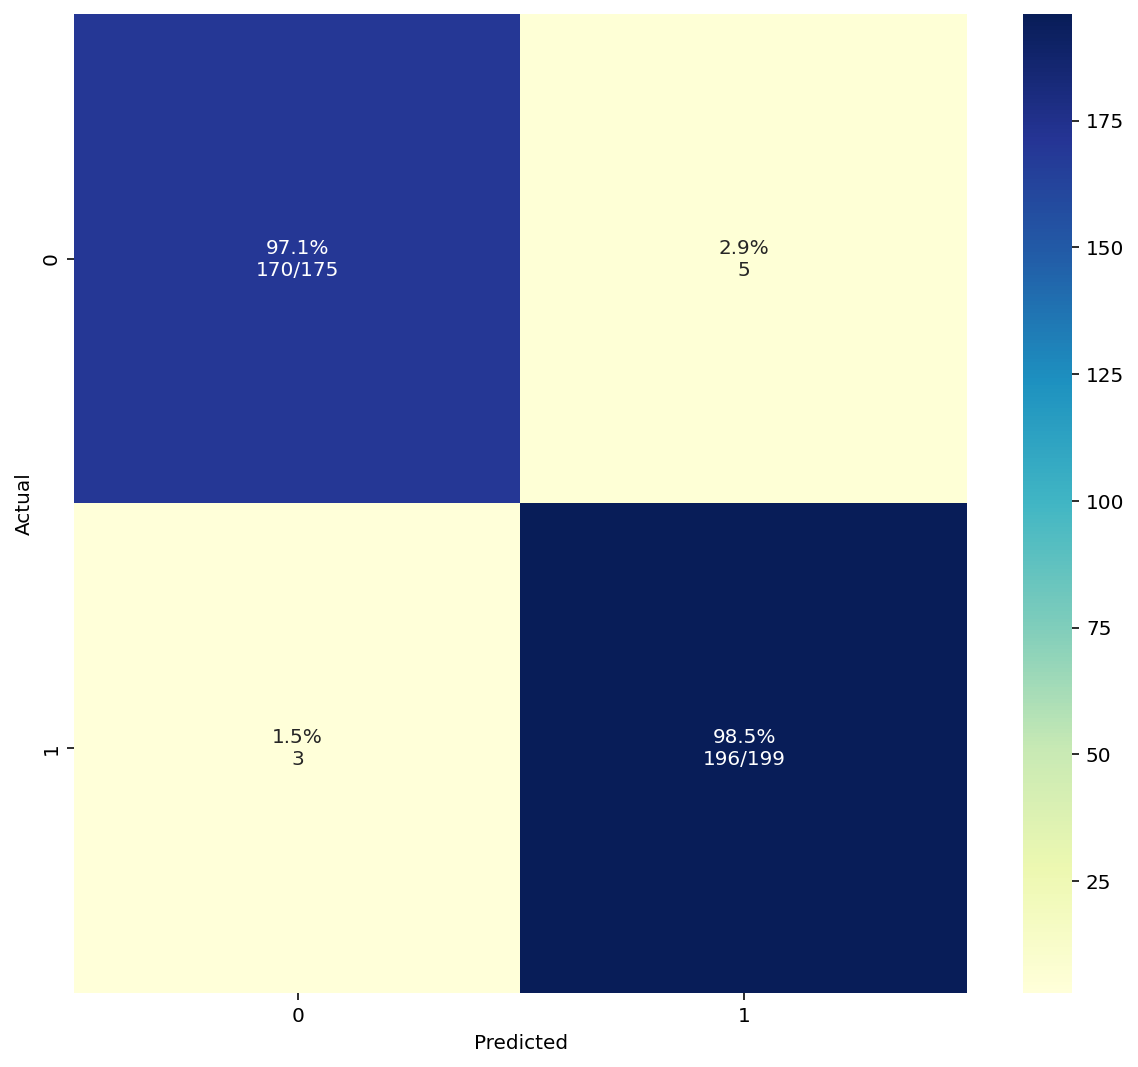

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns

def plot_cm(y_true, y_pred, figsize=(10,9)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

plot_cm(y_true, y_pred)

display()

In [ ]:
loss_l_c = []
acc_l_c = []
v_loss_l_c = []
v_acc_l_c = []
for x in loss_l:
    x = x.cpu().detach().numpy()
    loss_l_c.append(x)
for x in acc_l:
    x = x.cpu().detach().numpy()
    acc_l_c.append(x)
for x in v_loss_l:
    x = x.cpu().detach().numpy()
    v_loss_l_c.append(x)
for x in v_acc_l:
    x = x.cpu().detach().numpy()
    v_acc_l_c.append(x)

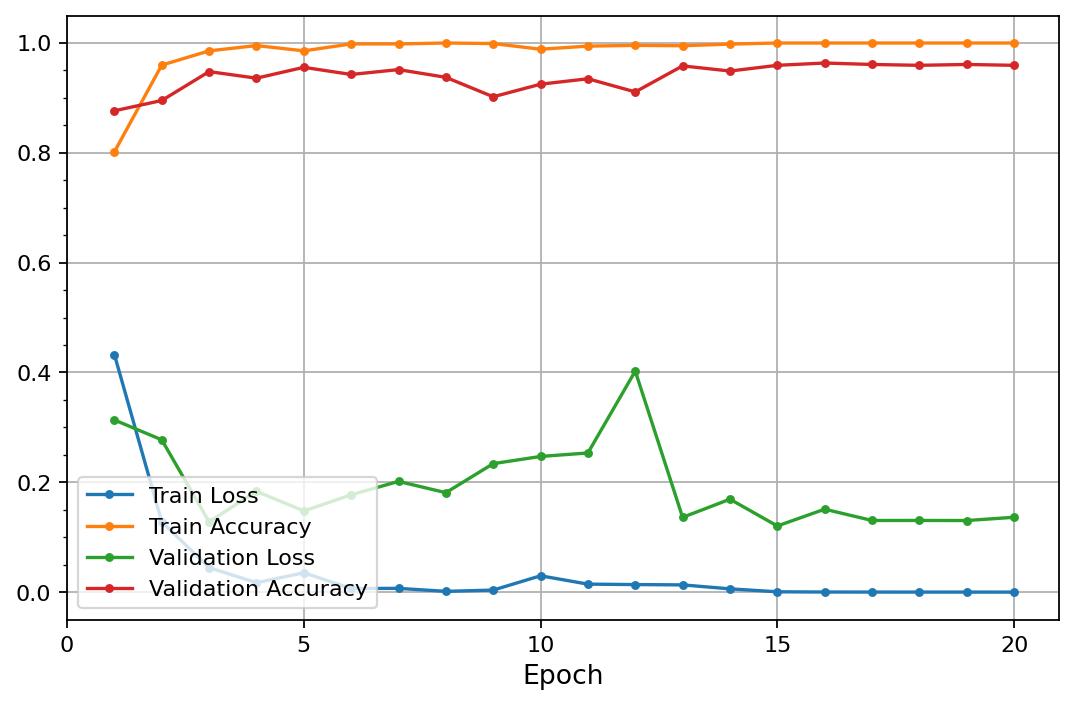

In [ ]:
plt.figure(figsize=(8, 5), dpi=80)

line_t_loss, = plt.plot(epoch_l, loss_l_c, label='Train Loss', marker=".")
line_t_acc, = plt.plot(epoch_l, acc_l_c, label='Train Accuracy', marker=".")
line_v_loss, = plt.plot(epoch_l, v_loss_l_c, label='Validation Loss', marker=".")
line_v_acc, = plt.plot(epoch_l, v_acc_l_c, label='Validation Accuracy', marker=".")

L = plt.legend(handles=[line_t_loss, line_t_acc, line_v_loss, line_v_acc], loc='lower left')

plt.minorticks_on()
plt.tick_params(axis='x', which='minor', bottom=False)

plt.xticks(np.arange(min(epoch_l)-1, max(epoch_l)+5, 5.0))
plt.yticks(np.arange(0, 1.1, 0.2))

plt.xlabel('Epoch', fontsize=12)

plt.grid()
plt.show()

### Inference

In [ ]:
def predict_image(image):
    image_tensor = TRANSFORM_IMG(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
classes = ['COVID', 'non-COVID']
def get_random_images(num):
    # classes = test_data.classes
    indices = list(range(len(test_data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(test_data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

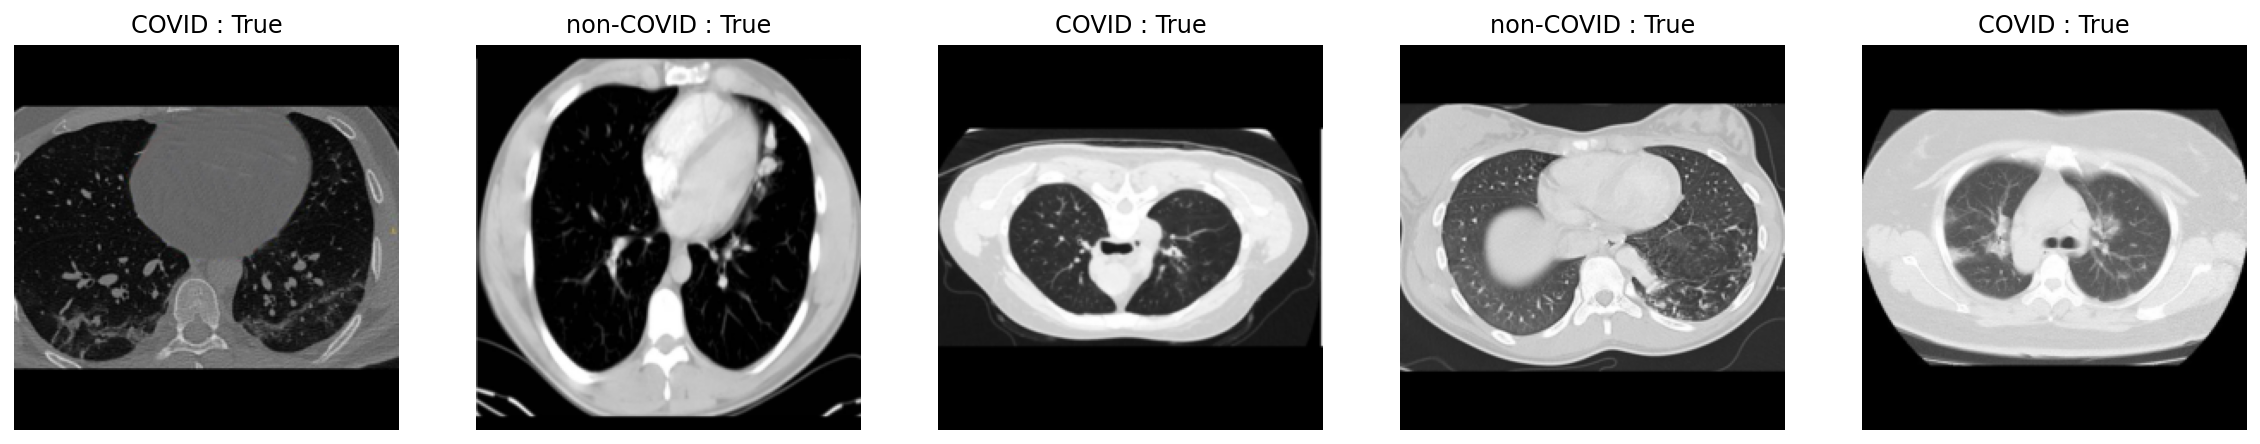

In [ ]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(20,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + " : " + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [ ]:
import shutil
shutil.copy('./convit_small_model_pretrained.pt','/content/gdrive/MyDrive/IUPESM')

'/content/gdrive/MyDrive/IUPESM/convit_small_model_pretrained.pt'